# Introduction

In this notebook, we will be creating a model to identify metastatic cancer in small images patches taken from larger pathology scans. 

In [35]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
from sklearn import metrics
import gc
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [36]:
sample_df = pd.read_csv("sample_submission.csv")
label_df = pd.read_csv("train_labels.csv")

# EDA

In [37]:
sample_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [38]:
label_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [39]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


Text(0.5, 1.0, 'Distribution of labels')

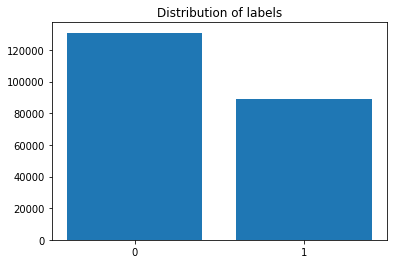

In [40]:
#label counts
plt.bar(x=['0','1'], height=label_df['label'].value_counts())
plt.title('Distribution of labels')

CANEROUS IMAGES; label=1


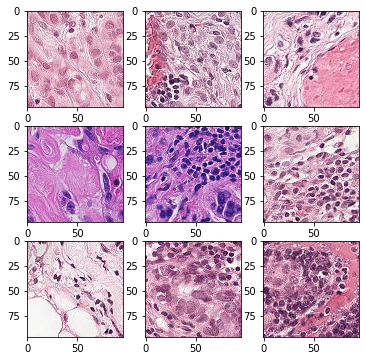

In [42]:
fig, ax = plt.subplots(3, 3, figsize=(6,6))
random_cancerous_ids = label_df[label_df.label == 1]['id'].sample(9).values

print("CANEROUS IMAGES; label=1")
i = 0
for r in range(3):
    for c in range(3):
        image_path = f"C:/Users/Vedhik/Documents/Master of Data Science/Intro to deep learning/train/{random_cancerous_ids[i]}.tif"
        img = Image.open(image_path)
        ax[r,c].imshow(img)
        i += 1
plt.show()

NONCANEROUS IMAGES; label=0


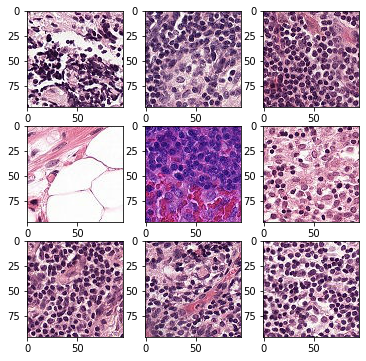

In [43]:
fig, ax = plt.subplots(3, 3, figsize=(6,6))
random_cancerous_ids = label_df[label_df.label == 0]['id'].sample(9).values

print("NONCANEROUS IMAGES; label=0")
i = 0
for r in range(3):
    for c in range(3):
        image_path = f"C:/Users/Vedhik/Documents/Master of Data Science/Intro to deep learning/train/{random_cancerous_ids[i]}.tif"
        img = Image.open(image_path)
        ax[r,c].imshow(img)
        i += 1
plt.show()

In [44]:
X_train, X_test, y_train, y_test = train_test_split(label_df['id'], label_df['label'], test_size=0.2, random_state=42)

# Model

My model consists of 3 convolutional layers with a maxpooling layer after each. Followed by 2 dense layers

In [45]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 128)     

In [46]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
label_df['label'] = label_df['label'].astype(str)

In [54]:
IMG_WIDTH, IMG_HEIGHT = 96,96
label_df['path'] = f"C:/Users/Vedhik/Documents/Master of Data Science/Intro to deep learning/train/" + label_df['id']+ ".tif"
label_df['label'] = label_df['label'].astype(str)
# Preparing data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Normalize images

train_generator = train_datagen.flow_from_dataframe(
    dataframe=label_df,
    x_col="path",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    class_mode="binary",
    subset="training",
    validate_filenames=False
)
val_generator = train_datagen.flow_from_dataframe(
    dataframe=label_df,
    x_col="path",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    class_mode="binary",
    subset="validation",
    validate_filenames=False
)


Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.


In [56]:
n_epochs = 10
steps_per_epoch=100
model_history = model.fit(
    train_generator,
    epochs=n_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=steps_per_epoch,
)

Epoch 1/10
100/100 [==============================] - 33s 334ms/step - loss: 0.5062 - accuracy: 0.7700 - val_loss: 0.4826 - val_accuracy: 0.7791
Epoch 2/10
100/100 [==============================] - 33s 330ms/step - loss: 0.4912 - accuracy: 0.7741 - val_loss: 0.4720 - val_accuracy: 0.7912
Epoch 3/10
100/100 [==============================] - 31s 314ms/step - loss: 0.4824 - accuracy: 0.7781 - val_loss: 0.4724 - val_accuracy: 0.7825
Epoch 4/10
100/100 [==============================] - 31s 309ms/step - loss: 0.4707 - accuracy: 0.7794 - val_loss: 0.4713 - val_accuracy: 0.7941
Epoch 5/10
100/100 [==============================] - 29s 295ms/step - loss: 0.4801 - accuracy: 0.7731 - val_loss: 0.4497 - val_accuracy: 0.7969
Epoch 6/10
100/100 [==============================] - 28s 285ms/step - loss: 0.4661 - accuracy: 0.7862 - val_loss: 0.4502 - val_accuracy: 0.7978
Epoch 7/10
100/100 [==============================] - 28s 281ms/step - loss: 0.4783 - accuracy: 0.7812 - val_loss: 0.4532 - val_ac

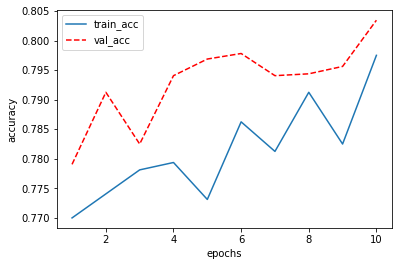

In [58]:
epochs = model_history.params['epochs']
x = [i for i in range(1,epochs+1)]
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(x, acc, label="train_acc")
plt.plot(x, val_acc, label="val_acc", linestyle="--", color="red")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()
plt.show()

# Discussion

This model performs well, with an accuracy of .80. We can see that there is a progressive increase in accuracy for both the training and validation data. This model can be improved by testing out other parameters, such as adding or removing layers, changing the number of epochs, or changing the learning rate. These would need to be explored further to improve this model